
Zero-Coupon Yields Results:
Maturity (years) | Discount Factor | Zero-Coupon Yield (%)
------------------------------------------------------------
          0.08 |         0.9962 |             4.9193
          0.25 |         0.9878 |             4.9303
          0.50 |         0.9760 |             4.8585
          1.00 |         0.9534 |             4.7721
          2.00 |         0.9207 |             4.1332
          3.00 |         0.8868 |             4.0055
          5.00 |         0.8343 |             3.6221
          7.00 |         0.7791 |             3.5668
         10.00 |         0.6988 |             3.5832
         30.00 |         0.3532 |             3.4687


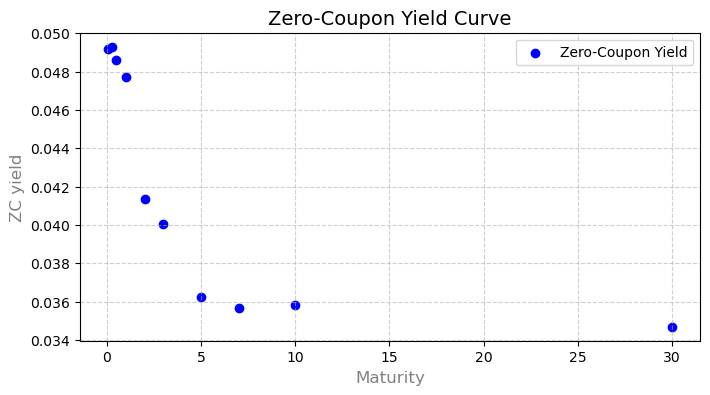

In [16]:
# 1
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

class ZeroCouponCalculator:
    def __init__(self):
        # Store yields for bills (expressed as percentages)
        self.bills_yields = {
            1/13: 4.91,  # 1-month
            1/4: 4.90,   # 3-month
            1/2: 4.80,   # 6-month
            1.0: 4.66    # 1-year
        }
        
        # Calculate discount factors for bills using yield
        self.bills_discount_factors = {
            t: 1 - y / 100 * t for t, y in self.bills_yields.items()
        }
        
        # Store known rates for bonds
        self.bond_rates = {
            2.0: 4.19,
            3.0: 4.06,
            5.0: 3.68,
            7.0: 3.62,
            10.0: 3.63,
            30.0: 3.51
        }
        
    def get_discount_factor(self, t):
        """
        Get discount factor for time t
        For t <= 1: retrieve from bills_discount_factors
        For 1 < t: interpolate if needed
        """
        if t in self.bills_discount_factors:
            return self.bills_discount_factors[t]
        elif t <= 1:
            # Find surrounding points and interpolate
            times = sorted(self.bills_discount_factors.keys())
            idx = np.searchsorted(times, t)
            t1, t2 = times[idx-1], times[idx]
            d1 = self.bills_discount_factors[t1]
            d2 = self.bills_discount_factors[t2]
            return (d1+d2)/2
        return None

    def calculate_bond_discount_factor(self, T, rate):
        """Calculate discount factor for a bond with maturity T"""
        rate = rate / 100  # Convert to decimal
        
        def bond_price_equation(P):
            price = 0
            # Calculate semi-annual coupon payments
            for i in range(1, int(T * 2) + 1):
                t = i / 2
                if t <= 1:
                    # Use stored bills discount factors
                    df = self.get_discount_factor(t)
                elif t > 1 and t < T:
                    if t.is_integer():
                        if t in self.bond_discount_factors:
                            df = self.bond_discount_factors[t]
                        else:
                            df = P ** (t / T)
                    else:
                        # For non-integer t > 1, use average of surrounding points
                        t_floor = int(t)
                        t_ceil = t_floor + 1
                        if t_floor == 1:
                            df_floor = self.bills_discount_factors[1.0]
                        else:
                            df_floor = self.bond_discount_factors.get(t_floor, P ** (t_floor / T))
                        df_ceil = self.bond_discount_factors.get(t_ceil, P ** (t_ceil / T))
                        df = (df_floor + df_ceil) / 2
                else:  # t = T
                    df = P
                
                price += (rate * 100 / 2) * df
            
            # Add final payment
            price += 100 * P
            return price - 100
        
        # Solve for the discount factor
        initial_guess = 1 / (1 + rate) ** T
        P = fsolve(bond_price_equation, x0=initial_guess)[0]
        return P

    def calculate_all_discount_factors(self):
        """Calculate discount factors for all bonds"""
        self.bond_discount_factors = {}
        
        # Calculate discount factors in order of maturity
        for T in sorted(self.bond_rates.keys()):
            P = self.calculate_bond_discount_factor(T, self.bond_rates[T])
            self.bond_discount_factors[T] = P
            
        return self.bond_discount_factors

    def calculate_zero_coupon_yields(self):
        """Calculate zero-coupon yields for all maturities"""
        # Calculate bond discount factors
        self.calculate_all_discount_factors()
        
        # Combine all discount factors
        all_discount_factors = {**self.bills_discount_factors, **self.bond_discount_factors}
        
        # Calculate zero-coupon yields
        zero_coupon_yields = {}
        for t, df in sorted(all_discount_factors.items()):
            zcy = -1 / t * np.log(df) * 100
            zero_coupon_yields[t] = zcy
        
        return zero_coupon_yields

def main():
    calculator = ZeroCouponCalculator()
    zero_coupon_yields = calculator.calculate_zero_coupon_yields()
    
    # Print results
    print("\nZero-Coupon Yields Results:")
    print("Maturity (years) | Discount Factor | Zero-Coupon Yield (%)")
    print("-" * 60)
    
    maturities = []
    zc_yields = []
    
    for t in sorted(zero_coupon_yields.keys()):
        df = calculator.bills_discount_factors.get(t) or calculator.bond_discount_factors.get(t)
        zcy = zero_coupon_yields[t]
        maturities.append(t)
        zc_yields.append(zcy / 100)  # Convert to decimal format
        
        print(f"{t:14.2f} | {df:14.4f} | {zcy:18.4f}")

    # Plot scatter chart
    plt.figure(figsize=(8, 4))
    plt.scatter(maturities, zc_yields, color='blue', label="Zero-Coupon Yield")

    # Labels and formatting
    plt.xlabel("Maturity", fontsize=12, color='gray')
    plt.ylabel("ZC yield", fontsize=12, color='gray')
    plt.title("Zero-Coupon Yield Curve", fontsize=14)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    # Display the chart
    plt.show()

if __name__ == "__main__":
    main()


Nelson-Siegel-Svensson Fitting Results:

Parameter | Value
--------------------
a         | 0.0345
b         | 0.0145
c         | 1.2039
d         | -1.1961
τ         | 0.9945
θ         | 1.0056

Minimized objective function: 6.12e-06

Note: τ and θ are very close - consider using the four-parameter Nelson-Siegel model instead.


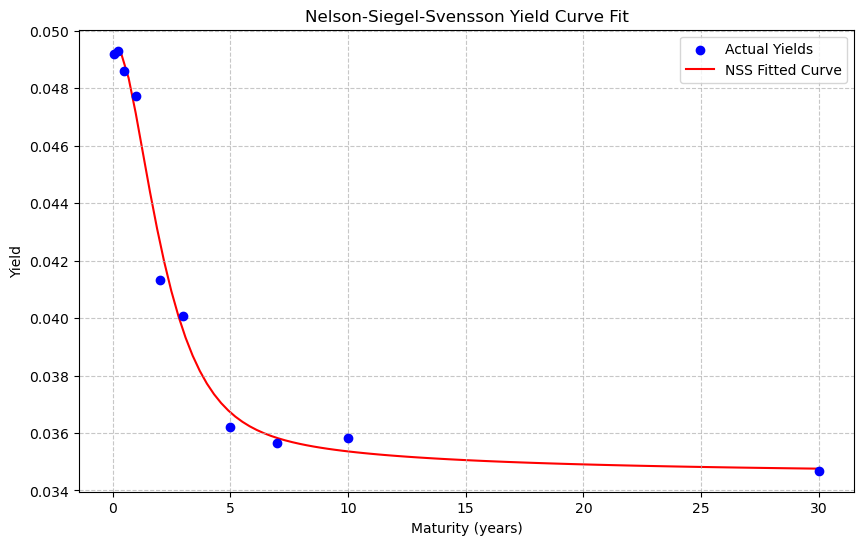

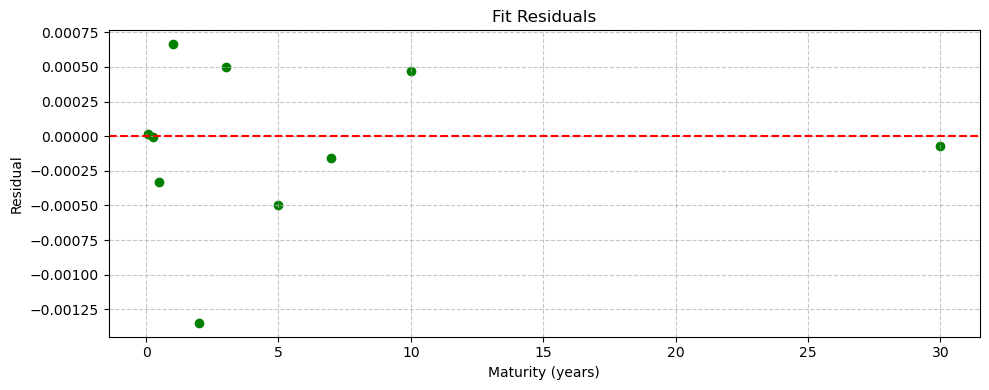

In [24]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def nss_yield(t, params):
    """
    Calculate yield using Nelson-Siegel-Svensson function
    params: [a, b, c, d, tau, theta]
    """
    a, b, c, d, tau, theta = params
    
    # Handle very small t values to avoid division by zero
    if t < 1e-10:
        t = 1e-10
    
    factor1 = (1 - np.exp(-t/tau)) / (t/tau)
    factor2 = factor1 - np.exp(-t/tau)
    factor3 = (1 - np.exp(-t/theta)) / (t/theta) - np.exp(-t/theta)
    
    return a + b*factor1 + c*factor2 + d*factor3

def objective_function(params, maturities, yields, weighted=True):
    """
    Calculate weighted sum of squared errors between actual and fitted yields
    With special weighting for short-end (1/t) and long-end (t) of the curve
    """
    fitted_yields = np.array([nss_yield(t, params) for t in maturities])
    errors = yields - fitted_yields
    
    if weighted:
        # Apply weights: 1/t for short end, t for long end
        # Use maturity of 2 years as the threshold between short and long end
        threshold = 2.0
        weights = np.where(maturities <= threshold, 
                          1/maturities,  # Short end: weight by 1/t
                          maturities)    # Long end: weight by t
        
        # Apply weights to squared errors
        weighted_errors = errors * errors * weights
        return np.sum(weighted_errors)
    else:
        return np.sum(errors * errors)

def fit_nss(maturities, yields, weighted=True):
    """
    Fit Nelson-Siegel-Svensson model to the yield curve
    """
    # Initial parameter guess
    initial_guess = [
        0.035,  # a (long-term level)
        0.01,   # b
        1.2,    # c
        -1.2,   # d
        1.0,    # tau
        1.0     # theta
    ]
    
    # Parameter bounds
    bounds = [
        (0, 0.1),     # a
        (-0.1, 0.1),  # b
        (-2, 2),      # c
        (-2, 2),      # d
        (0.1, 10),    # tau
        (0.1, 10)     # theta
    ]
    
    # Minimize objective function
    result = minimize(
        objective_function,
        initial_guess,
        args=(maturities, yields, weighted),
        bounds=bounds,
        method='L-BFGS-B'
    )
    
    return result

# Example usage (assuming you have zero_coupon_yields from previous code):
calculator = ZeroCouponCalculator()
zero_coupon_yields = calculator.calculate_zero_coupon_yields()

# Convert dictionary to arrays for fitting
maturities = np.array(list(zero_coupon_yields.keys()))
yields = np.array(list(zero_coupon_yields.values())) / 100  # Convert to decimal

# Fit NSS model with weighted objective function
result = fit_nss(maturities, yields, weighted=True)

# Print results in the requested format
print("\nNelson-Siegel-Svensson Fitting Results:")
print("\nParameter | Value")
print("-" * 20)
param_names = ['a', 'b', 'c', 'd', 'τ', 'θ']
for name, value in zip(param_names, result.x):
    print(f"{name:9} | {value:.4f}")

print(f"\nMinimized objective function: {result.fun:.2e}")

if abs(result.x[4] - result.x[5]) < 0.1:  # Check if tau and theta are close
    print("\nNote: τ and θ are very close - consider using the four-parameter Nelson-Siegel model instead.")

# Generate fitted curve for plotting
t_fine = np.linspace(min(maturities), max(maturities), 100)
fitted_yields = [nss_yield(t, result.x) for t in t_fine]

# Plot results
plt.figure(figsize=(10, 6))

# Plot actual yields
plt.scatter(maturities, yields, color='blue', label='Actual Yields', zorder=2)

# Plot fitted curve
plt.plot(t_fine, fitted_yields, 'r-', label='NSS Fitted Curve', zorder=1)

plt.xlabel('Maturity (years)')
plt.ylabel('Yield')
plt.title('Nelson-Siegel-Svensson Yield Curve Fit')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Calculate and plot residuals
plt.figure(figsize=(10, 4))
fitted_at_points = np.array([nss_yield(t, result.x) for t in maturities])
residuals = yields - fitted_at_points

plt.scatter(maturities, residuals, color='green')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Maturity (years)')
plt.ylabel('Residual')
plt.title('Fit Residuals')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [1]:
# example of Q3 for HW model example in the note

import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import pandas as pd

# Function for NSS Zero-Coupon Yield Curve, zcy(T)
def zcy(T):
    """
    Nelson-Siegel-Svensson (NSS) Zero-Coupon Yield Curve.
    :param T: time (yearly)
    :param beta0, beta1, beta2, beta3, tau1, tau2: NSS parameters get from Q2
    :return: zcy(T)
    """
    beta0 = 0.880289
    beta1 = 0.7877936
    beta2 = -0.000083
    beta3 = 5.219559
    tau1 = 2.069307
    tau2 = 24.692337
    
    term1 = (1 - np.exp(-T/tau1)) / (T/tau1)
    term2 = term1 - np.exp(-T/tau1)
    term3 = (1 - np.exp(-T/tau2)) / (T/tau2) - np.exp(-T/tau2)
    return (beta0 + beta1 * term1 + beta2 * term2 + beta3 * term3)*0.01

# Function for discount factor, P(t,T)
def P(T):
    """
    Compute P(t,T) by using zcy(T)
    :param t: current time, 0.003
    :param T: future time, yearly
    :return: P(t, T)
    """
    #t = 0
    
    z_T = zcy(T)
    #z_t = zcy(t)
    return np.exp(-z_T * (T))

# Function for the Forward Rate, F(T1,T2)
def forward_rate(T1, T2):
    """
    Compute F(t, T1, T2)
    :param T1: start time
    :param T2: end time
    :return: F(T1, T2)
    """
    P_t_T1 = P(T1)
    P_t_T2 = P(T2)
    return (1 / (T2 - T1)) * np.log(P_t_T1 / P_t_T2)

# Function for the Instantaneous Forward Rate, f(0,t) NSS
def instantaneous_forward_rate(T):
    """
    Compute f(T)
    :param T: yealy date
    :return: f(T)
    """
    dt = 0.01
    P_T = P(T)
    P_T_plus_dt = P(T + dt)
    
    return -(1/dt) * np.log(P_T_plus_dt/P_T)

In [3]:
# Function for Forward Swap Rate K_f
def Kf(T):
    """
    Compute Forward Swap Rate K_f
    :param tau: quarterly settlement dates (0.25)
    :return: K_f
    """
    tau = 0.25
    denominator = 0
    
    numerator = P(tau) - P(T)
    for t in np.arange(2 * tau, T + tau, tau):
        denominator += tau * P(t)
    
    return numerator / denominator

In [5]:
# parameters
T_values = [1, 2, 3, 4, 5, 7, 10]

# Strike Matrix
# Calculate Forward Swap Rate Kf
strikes = {T: Kf(T) for T in T_values}

# IV Matrix
sigmas = [0.3103, 0.3717, 0.4027, 0.4225, 0.4266, 0.4117, 0.3647]

In [7]:
# Using Black Formula to calculate the cap market price
import numpy as np
import pandas as pd
from scipy.stats import norm

def cap_mkt_price(tn, K, sigma):
    """
    :param tn: maturity time
    :param K: Strike Price
    :param sigma: Implied Volatility
    :param P_values:P(t, T)
    :param F_values: Forward Rate F(t_{j-1}, t_j)
    :return: Cap market price
    """

    cap_sum = 0
    tau = 0.25
    t_values = np.arange(tau, tn + tau, tau)  # Generate time points t_j

    for i in range(len(t_values) - 1):  # Loop through time periods

        # Get the forward rate and discount factor
        F_j = forward_rate(t_values[i], t_values[i + 1])  # Forward rate for the period (t_{j-1}, t_j)
        P_j = P(t_values[i + 1])  # Discount factor for t_j

        # Compute v_j (volatility adjustment)
        v_j = sigma * np.sqrt(t_values[i])

        # Compute d1 and d2 for Black's formula
        d1 = (np.log(F_j / K) + 0.5 * v_j**2) / v_j
        d2 = (np.log(F_j / K) - 0.5 * v_j**2) / v_j

        # Compute the caplet price using Black's formula
        caplet_price = tau * P_j * (F_j * norm.cdf(d1) - K * norm.cdf(d2))
        cap_sum += caplet_price  # Accumulate caplet prices

    return cap_sum  # Return the total cap price

In [9]:
import pandas as pd

# 初始化 DataFrame
cap_mkt_prices_df = pd.DataFrame(index=T_values, columns=["Cap Price"])

# 计算 Cap 价格
for i, (T, K) in enumerate(strikes.items()):  
    sigma = sigmas[i]  # 取对应的 Implied Volatility
    tn = T_values[i]   # 取对应的 Maturity

    # 计算 Cap 价格
    cap_mkt_prices_df.loc[T, "Cap Price"] = cap_mkt_price(tn, K, sigma)

# 添加 Maturity (years) 列
cap_mkt_prices_df.insert(0, "Maturity (years)", T_values)
cap_mkt_prices_df

,Maturity (years),Cap Price
1,1,0.000997
2,2,0.003802
3,3,0.007821
4,4,0.012915
5,5,0.018615
7,7,0.031086
10,10,0.05001


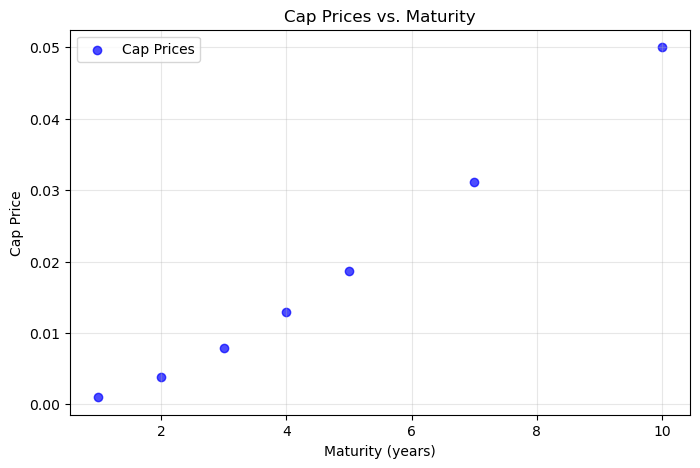

In [11]:
# 由于代码执行状态被重置，我需要重新定义数据再进行绘图

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 绘制散点图
plt.figure(figsize=(8, 5))
plt.scatter(cap_mkt_prices_df["Maturity (years)"], cap_mkt_prices_df["Cap Price"], 
            color="blue", label="Cap Prices", alpha=0.7)
plt.xlabel("Maturity (years)")
plt.ylabel("Cap Price")
plt.title("Cap Prices vs. Maturity")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()